# NDVI prediction for deforestation

In [31]:
import pandas as pd
import geopandas as gpd
import folium
import os, shutil
from glob import glob
path = '/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/data_folder/month_1-4'

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [23]:
!pip3 install geopandas

In [32]:
cd /content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement

/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement


In [99]:

from ipyleaflet import *
from geojson import Point, Feature, FeatureCollection, dump
def handle_draw(self, action, geo_json):
    print(action)
    print('geo_json:',geo_json)
    with open('myfile.geojson', 'w') as f:
      dump(geo_json, f)
    

m = Map(center=[26.178685,90.63377], zoom=8, name = 'Study Area', basemap = basemaps.OpenStreetMap.Mapnik, scroll_wheel_zoom = True)
tl = TileLayer(name = 'Satellite Tile View', url = 'http://www.google.cn/maps/vt?lyrs=s@189&gl=cn&x={x}&y={y}&z={z}')
m.add_layer(tl)
control = FullScreenControl(position='topleft')  
dc = DrawControl(marker={'shapeOptions': {'color': 'red'}},
                 rectangle={'shapeOptions': {'color': 'blue'}})
    
dc.on_draw(handle_draw)
m.add_control(control) 
# m.LatLngPopup()
m.add_control(dc)
m.add_control(LayersControl(position='topright'))
m

Map(center=[26.178685, 90.63377], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', …

created
geo_json: {'geometry': {'type': 'Polygon', 'coordinates': [[[87.33, 26.788994], [87.330622, 26.787692], [87.332628, 26.788487], [87.332092, 26.78931], [87.33, 26.788994]]]}, 'type': 'Feature', 'properties': {'style': {'opacity': 0.5, 'fillOpacity': 0.2, 'weight': 4, 'color': '#3388ff', 'stroke': True, 'fillColor': None, 'clickable': True, 'fill': True}}}


In [24]:
bounds = gpd.read_file('/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/myfile.geojson')
bounds

style                                           geometry
0  {'opacity': 0.5, 'fillOpacity': 0.2, 'weight':...  POLYGON ((87.33000 26.78899, 87.33062 26.78769...

In [25]:
tiles = gpd.read_file(r"/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/sentinel2_tiles_world.shp")

In [26]:
tiles_intersection = tiles[tiles.intersects(bounds.geometry[0])]
tiles_intersection = tiles_intersection.reset_index(drop = True)

In [27]:
import numpy as np
xy = np.asarray(bounds.centroid[0].xy).squeeze()
center = list(xy[::-1])
zoom = 6
m = folium.Map(location=center, zoom_start=zoom, control_scale=True)
m.add_child(folium.GeoJson(bounds.__geo_interface__, name='Area of Study', 
                            style_function=lambda x: {'color': 'red', 'alpha': 0}))
# m.add_child(folium.GeoJson(bounds1.__geo_interface__, name='Area of Study', 
#                            style_function=lambda x: {'color': 'green', 'alpha': 0}))

g = folium.GeoJson(tiles_intersection.geometry.__geo_interface__, name = 'Sentinel-2 Tiles')
g.add_to(m)

folium.LayerControl().add_to(m)
m.save('tiles.html')
m

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  


# Use sentinel API

In [119]:
# connect to the API
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date

api = SentinelAPI('use user key', 'password', 'https://scihub.copernicus.eu/dhus')

# download single scene by known product id
#api.download(<product_id>)

# search by polygon, time, and SciHub query keywords##geojson_to_wkt(read_geojson('chandhan.geojson'))
footprint = geojson_to_wkt(read_geojson('/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/myfile.geojson'))
products = api.query(footprint,
                     date=('20200201', '20210101'),
                     platformname='Sentinel-2')

# download all results from the search
#a=api.download_all(products)

# convert to Pandas DataFrame
#products_df = api.to_dataframe(products)

# GeoJSON FeatureCollection containing footprints and metadata of the scenes
#api.to_geojson(products)

# GeoPandas GeoDataFrame with the metadata of the scenes and the footprints as geometries
data=api.to_geodataframe(products)

# Get basic information about the product: its title, file size, MD5 sum, date, footprint and
# its download url
#api.get_product_odata(<product_id>)

# Get the product's full metadata available on the server
#api.get_product_odata(<product_id>, full=True)


Querying products:  75%|#######4  | 100/134 [00:00<?, ?product/s]

In [120]:
data = data.reset_index(drop = True)
data.columns

Index(['title', 'link', 'link_alternative', 'link_icon', 'summary', 'ondemand',
       'beginposition', 'endposition', 'ingestiondate', 'orbitnumber',
       'relativeorbitnumber', 'vegetationpercentage', 'notvegetatedpercentage',
       'waterpercentage', 'unclassifiedpercentage',
       'mediumprobacloudspercentage', 'highprobacloudspercentage',
       'snowicepercentage', 'cloudcoverpercentage', 'level1cpdiidentifier',
       'format', 'processingbaseline', 'platformname', 'filename',
       'instrumentname', 'instrumentshortname', 'size', 's2datatakeid',
       'producttype', 'platformidentifier', 'orbitdirection',
       'platformserialidentifier', 'processinglevel', 'identifier', 'uuid',
       'datatakesensingstart', 'sensoroperationalmode', 'tileid',
       'hv_order_tileid', 'granuleidentifier', 'datastripidentifier',
       'geometry'],
      dtype='object')

In [121]:
df = data[data.contains(bounds.geometry[0])]
df = df.reset_index(drop = True)
type(df)

geopandas.geodataframe.GeoDataFrame

# Best product tiles

In [122]:

#ndvi map from raster in python
def cal_month_list(starting_month, starting_year):
    year_month_list = []
    for i in range(int(starting_month),int(starting_month)+10):  
        if(i<=12):
            month_val = "-"  + str(i).zfill(2)              
            year_month_list.append(starting_year + month_val)        
        else:            
            month_val = '-0'+str(i-12)           
            year_month_list.append(str(int(starting_year)+1) + month_val) 
    return year_month_list

starting_month = '2'
starting_year = '2020'

year_month_list = cal_month_list(starting_month, starting_year)
print('tear month list:', year_month_list)
#getting starting date and query_end_date using year_month_list[3]
query_start_date = (starting_year + starting_month.zfill(2) + '01')
query_end_date = year_month_list[3][0:4]+year_month_list[3][5:7]+"01"
#discarding 3rd row of year_month_list
year_month_list = year_month_list
#Querying products using sentinel api for given area(geojson)
products_df = df
# finding unique tiles in product dataframe
tile_id = list(products_df.title.str.slice(39,44))
tile_list = list(set(tile_id))
no_of_tiles = len(tile_list)
no_of_months = len(year_month_list)
print(no_of_months)
# creating product array of size no_of_tiles*no_of_month to store title of required products that will be used in downloading 
best_products_tiles = np.empty([no_of_tiles,no_of_months], dtype=object)
print(best_products_tiles)
# fiiling product array with best cloud cover tile for respective tile and month
for tile_index in range(len(tile_list)):
    dataframe_tile_id = products_df[(products_df.title.str.contains(tile_list[tile_index]))]
    for year_month_index in range(len(year_month_list)):
        dataframe  = dataframe_tile_id[(dataframe_tile_id.summary.str.contains(year_month_list[year_month_index]))]
        print(dataframe)
        best_data = dataframe.sort_values('cloudcoverpercentage').iloc[0]
        best_products_tiles[tile_index][year_month_index] = best_data['title']
del products_df

tear month list: ['2020-02', '2020-03', '2020-04', '2020-05', '2020-06', '2020-07', '2020-08', '2020-09', '2020-10', '2020-11']
10
[[None None None None None None None None None None]]
                                                 title  ...                                           geometry
122  S2B_MSIL2A_20200227T044739_N0214_R076_T45RWK_2...  ...  MULTIPOLYGON (((87.88853 26.12769, 87.92819 26...
123  S2B_MSIL1C_20200227T044739_N0209_R076_T45RWK_2...  ...  MULTIPOLYGON (((87.88853 26.12769, 87.92819 26...
124  S2A_MSIL2A_20200222T044811_N0214_R076_T45RWK_2...  ...  MULTIPOLYGON (((87.89272 26.12768, 87.90068 26...
125  S2A_MSIL1C_20200222T044811_N0209_R076_T45RWK_2...  ...  MULTIPOLYGON (((87.89272 26.12768, 87.90068 26...
126  S2B_MSIL2A_20200217T044849_N0214_R076_T45RWK_2...  ...  MULTIPOLYGON (((87.89079 26.12768, 87.89542 26...
127  S2B_MSIL1C_20200217T044849_N0209_R076_T45RWK_2...  ...  MULTIPOLYGON (((87.89079 26.12768, 87.89542 26...
128  S2A_MSIL2A_20200212T044921_N0214_

In [123]:
best_products_tiles

array([['S2B_MSIL1C_20200207T044949_N0209_R076_T45RWK_20200207T074128',
        'S2B_MSIL1C_20200328T044659_N0209_R076_T45RWK_20200328T082520',
        'S2B_MSIL1C_20200407T044659_N0209_R076_T45RWK_20200407T082519',
        'S2B_MSIL1C_20200507T044659_N0209_R076_T45RWK_20200507T082427',
        'S2A_MSIL1C_20200611T044711_N0209_R076_T45RWK_20200611T075259',
        'S2B_MSIL1C_20200716T044659_N0209_R076_T45RWK_20200716T074928',
        'S2B_MSIL1C_20200825T044709_N0209_R076_T45RWK_20200825T064749',
        'S2A_MSIL1C_20200919T044701_N0209_R076_T45RWK_20200919T065952',
        'S2A_MSIL1C_20201029T044921_N0209_R076_T45RWK_20201029T064813',
        'S2B_MSIL2A_20201113T045039_N0214_R076_T45RWK_20201113T073222']],
      dtype=object)

In [66]:
#import required libraries
import rasterio
from rasterio import plot
import matplotlib.pyplot as plt
from skimage.transform import rescale, resize
import pandas as pd
from flask import Flask, render_template, url_for, redirect, request, jsonify, Response 
import numpy as np
#from sentinelhub import AwsTile
import os
import geopandas as gpd
import json
import rasterio
from rasterio import MemoryFile
import matplotlib.pyplot as plt
from rasterio.merge import merge
import datetime
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from rasterio.mask import mask
from shapely.geometry import box
from fiona.crs import from_epsg
import boto3
from rasterio.warp import calculate_default_transform
import folium
import time
import imageio
%matplotlib inline
# path = r'C:\Users\parag\Desktop\python\sentinel geojson\data'

In [120]:
!pip3 install rasterio

In [67]:
ACCESS_KEY = 'ACCESS_KEY '
SECRET_KEY = 'SECRET_KEY'

#s3_client = boto3.client('s3','us-east-1', aws_access_key_id = ACCESS_KEY, aws_secret_access_key = SECRET_KEY)
s3_client_upload = boto3.client('s3','us-east-1', aws_access_key_id = ACCESS_KEY, 
                                aws_secret_access_key = SECRET_KEY)
s3_client = boto3.Session(aws_access_key_id=ACCESS_KEY,aws_secret_access_key=SECRET_KEY).client('s3')


In [87]:
cd /content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/data_folder/MONTHLY-DATA

/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/data_folder/MONTHLY-DATA


In [90]:
import geopandas
import matplotlib.pyplot as plt
import rasterio
import rasterio.plot
bands = ['B04','B08']
path = '/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/data_folder/MONTHLY-DATA/'

# Download band data

In [ ]:

for i in range(0,best_products_tiles[0].shape[0]):
    product_tile = best_products_tiles[0][i]
    tile_name, time, aws_index = product_tile[39:44], product_tile[11:15]+'-'+product_tile[15:17]+'-'+product_tile[17:19], 0
    print(tile_name, time, aws_index)
    for band_index in range(len(bands)):
        
        key = 'tiles/'+ str(int(tile_name[:2]))+'/'+str(tile_name[2])+'/'+ str(tile_name[3:])+'/'+str(pd.to_datetime(time).date().year)+'/'+str(pd.to_datetime(time).date().month)+'/'+str(pd.to_datetime(time).date().day)+'/'+str(aws_index)+'/'+bands[band_index]+'.jp2'
        print(key)

#         s3_client = boto3.Session(aws_access_key_id=ACCESS_KEY,
#         aws_secret_access_key=SECRET_KEY).client('s3')
        res = s3_client.get_object(Bucket='sentinel-s2-l1c',
        Key=key, RequestPayer='requester')
        response_content = res['Body'].read()
        download_path =path + product_tile + bands[band_index] +".jp2"
        print('download_path:',download_path)
        with open(download_path, 'wb') as file:
                         file.write(response_content)
                         file.close()

In [ ]:
images = []
for file in os.listdir(path):
    if file.startswith('S'):
        print(file)
        with rasterio.open(path + file, driver='JP2OpenJPEG') as data:
                transform, width, height = calculate_default_transform(data.crs, 
                                'EPSG:4326', data.width, data.height, *data.bounds)
                memfile =  MemoryFile() #as memfile:
                data1 = memfile.open(driver='Gtiff',width=width, height=height,
                                count=1,crs='EPSG:4326',transform=transform,dtype='float32')
                reshaped_data = np.array([data.read(1)])     
                data1.write(reshaped_data.astype('float32'))
                images.append(data1)
images

# Helper function

In [93]:
def generate_bbox(geo_json):
    bounds = gpd.read_file(geo_json)
    return bounds.geometry

In [94]:
bbox = generate_bbox('/content/drive/MyDrive/blue_sky_assigement/blue_sky_assigement/myfile.geojson')

In [95]:
def getFeatures(gdf):
    """Function to parse features from GeoDataFrame in such a manner that rasterio wants them"""
    return [json.loads(gdf.to_json())['features'][0]['geometry']]

In [96]:
def getmasked(src_files_to_mosaic, bbox):
    mosaic, out_trans = merge(src_files_to_mosaic)
#     for file in src_files_to_mosaic:
#         file.close()
    #Writing mosaiic as a tif with meta data using source file 
    with MemoryFile() as memfile:
        with memfile.open(driver='Gtiff',width=mosaic.shape[2], height=mosaic.shape[1], count=1, crs=src_files_to_mosaic[0].crs, transform=out_trans, dtype='float32') as data:
            data.write(mosaic)
            del mosaic
            geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=from_epsg(4326))
            geo = geo.to_crs(crs=data.crs.data)
            coords = getFeatures(geo['geometry'])
            #mask the mosaiced file with bounding box
            out_img, out_transform = mask(data, coords, crop = True)
            memfile1 = MemoryFile() #as memfile1:
            data1 = memfile1.open(driver='Gtiff',width=out_img.shape[2], height=out_img.shape[1], count=1, crs=src_files_to_mosaic[0].crs, transform=out_transform, dtype='float32')# as data1:
            data1.write(out_img)
            return data1

In [97]:
def cal_band_array(band1_arr, band2_arr):
    indice_arr = np.zeros(band1_arr.shape, dtype = band1_arr.dtype)
    for i in range(band1_arr.shape[0]):
        for j in range(band1_arr.shape[1]):
            if (band1_arr[i][j] + band2_arr[i][j] == 0.0):
                indice_arr[i][j] = 0.0
            else:
                indice_arr[i][j] = (band1_arr[i][j]-band2_arr[i][j])/(band1_arr[i][j]+band2_arr[i][j])
    return indice_arr

# NDVI for feb month

In [98]:

b08_feb = getmasked( [images[1]], bbox)
b04_feb = getmasked([images[0]], bbox)
ndvi_feb = cal_band_array(b08_feb.read(1), b04_feb.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for march month

In [99]:

b08_march = getmasked( [images[3]], bbox)
b04_march = getmasked([images[2]], bbox)
ndvi_march = cal_band_array(b08_march.read(1), b04_march.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for april month

In [100]:
b08_april = getmasked( [images[5]], bbox)
b04_april = getmasked([images[4]], bbox)
ndvi_april = cal_band_array(b08_april.read(1), b04_april.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for may month

In [101]:
b08_may = getmasked( [images[7]], bbox)
b04_may = getmasked([images[6]], bbox)
ndvi_may = cal_band_array(b08_may.read(1), b04_may.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for june month

In [102]:
b08_june = getmasked( [images[9]], bbox)
b04_june = getmasked([images[8]], bbox)
ndvi_june = cal_band_array(b08_june.read(1), b04_june.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for july month

In [ ]:
b08_july = getmasked( [images[11]], bbox)
b04_july = getmasked([images[10]], bbox)
ndvi_july = cal_band_array(b08_july.read(1), b04_july.read(1))


# NDVI for aug month

In [104]:
b08_aug = getmasked( [images[13]], bbox)
b04_aug = getmasked([images[12]], bbox)
ndvi_aug = cal_band_array(b08_aug.read(1), b04_aug.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for sept month

In [105]:
b08_sept = getmasked( [images[15]], bbox)
b04_sept = getmasked([images[14]], bbox)
ndvi_sept = cal_band_array(b08_sept.read(1), b04_sept.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for oct month

In [106]:
b08_oct = getmasked( [images[17]], bbox)
b04_oct = getmasked([images[16]], bbox)
ndvi_oct = cal_band_array(b08_oct.read(1), b04_oct.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

# NDVI for nov month

In [107]:
b08_nov = getmasked( [images[19]], bbox)
b04_nov = getmasked([images[18]], bbox)
ndvi_nov = cal_band_array(b08_nov.read(1), b04_nov.read(1))


/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: CRS mismatch between CRS of the passed geometries and 'crs'. Use 'GeoDataFrame.set_crs(crs, allow_override=True)' to overwrite CRS or 'GeoDataFrame.to_crs(crs)' to reproject geometries. CRS mismatch will raise an error in the future versions of GeoPandas.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of

In [108]:

feb_avg_ndvi = np.average(ndvi_feb)
march_avg_ndvi = np.average(ndvi_march)
april_avg_ndvi = np.average(ndvi_april)
may_avg_ndvi = np.average(ndvi_may)
june_avg_ndvi = np.average(ndvi_june)
july_avg_ndvi = np.average(ndvi_july)
aug_avg_ndvi = np.average(ndvi_aug)
sept_avg_ndvi = np.average(ndvi_sept)
oct_avg_ndvi = np.average(ndvi_oct)
nov_avg_ndvi = np.average(ndvi_nov)

In [109]:
ndvi_sept.shape

(18, 29)

In [110]:
import numpy as np
print('aug avg: ', np.average(ndvi_aug))
print('sept avg: ',  np.average(ndvi_july))
print('oct avg: ',  np.average(ndvi_oct))

aug avg:  0.39590344
sept avg:  0.36497328
oct avg:  0.3820082


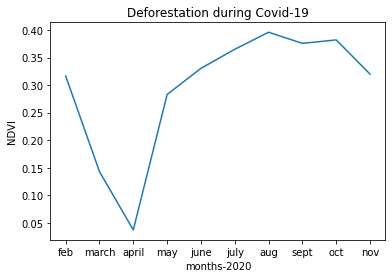

In [111]:
import matplotlib.pyplot as plt
x = ['feb', 'march','april','may','june','july','aug', 'sept', 'oct', 'nov']
y = [feb_avg_ndvi, march_avg_ndvi, april_avg_ndvi, may_avg_ndvi, june_avg_ndvi, july_avg_ndvi, aug_avg_ndvi, sept_avg_ndvi, oct_avg_ndvi, nov_avg_ndvi]

plt.plot(x,y)
plt.xlabel("months-2020")
plt.ylabel("NDVI")
plt.title("Deforestation during Covid-19")
plt.show()

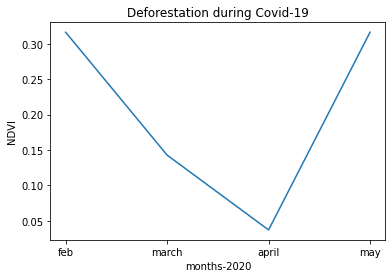

In [63]:
import matplotlib.pyplot as plt
x = ['feb','march','april','may']
y = [feb_avg_ndvi, march_avg_ndvi, april_avg_ndvi, may_avg_ndvi]

plt.plot(x,y)
plt.xlabel("months-2020")
plt.ylabel("NDVI")
plt.title("Deforestation during Covid-19")
plt.show()

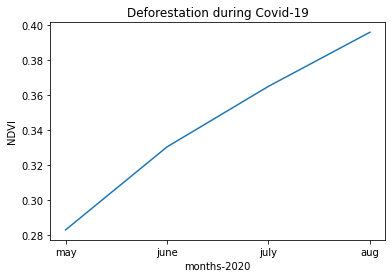

In [19]:
import matplotlib.pyplot as plt
x = ['may','june','july','aug']
y = [may_avg_ndvi, june_avg_ndvi, july_avg_ndvi, aug_avg_ndvi]

plt.plot(x,y)
plt.xlabel("months-2020")
plt.ylabel("NDVI")
plt.title("Deforestation during Covid-19")
plt.show()